# Main Notebook

In [6]:
import os
import gc
import pytz
import operator
import numpy as np
import pickle as pkl
import matplotlib as mtp
from time import sleep
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import finn_data
import tensorflow as tf
from tensorflow import math
import keras
from keras import layers
from keras.models import Sequential
from keras.activations import relu, elu
from keras.layers import Dense, Dropout
from talos.model import early_stopper
from talos.utils.best_model import activate_model
from talos import Evaluate
import talos
from talos import Reporting
from talos import Deploy
from talos import Restore
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import finn_data
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action = 'ignore', category = FutureWarning)
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import sys
sys.path.append('..')

time = datetime.now(pytz.timezone('Europe/Oslo')).strftime('%m.%d.%Y_%H.%M.%S')
print(f'Notebook initialized execution at {time}.')
#import xgboost as xgb

Notebook initialized execution at 04.21.2020_12.43.08.


## General Methods

In [7]:
def memory_optimization(dfs):
    for df in dfs:
        del df
    gc.collect()

## Prepare Data

In [8]:
import datasets

start_time = datetime.now()
scaler = MinMaxScaler()
train_x, train_y, validation_x, validation_y, test_x, test_y, scaler = datasets.load(f'../input/hele_norge.csv', scaler)

cleaning removed 1.06 % of the original values


# Optimization Parameters

In [48]:
parameters = {'activation_1':['relu', 'elu'],
     'activation_2':['relu', 'elu'],
     'activation_3':['relu', 'elu'],
     'optimizer': ['Adam', "RMSprop"],
     'loss-functions': ['mse'],
     'neurons_HL1': [50, 100, 200, 400],
     'neurons_HL2': [40, 80, 160, 320],
     'neurons_HL3': [40, 80, 160, 320, None],
     'dropout1': [0.1, 0.2, 0.3],
     'dropout2': [0.1, 0.2, 0.3],
     'batch_size': [100, 250, 500],
     'epochs': [400, 900]
}

In [49]:
def talolos(x_train, y_train, x_val, y_val, parameters):
    model = Sequential()

    model.add(Dense(parameters['neurons_HL1'], 
    input_shape=(train_x.shape[1],), 
    activation=parameters['activation_1'],use_bias=True))

    model.add(Dropout(parameters['dropout1']))

    model.add(Dense(parameters['neurons_HL2'], 
    activation=parameters['activation_2'], use_bias=True))

    model.add(Dropout(parameters['dropout1']))
    
    if parameters['neurons_HL3']:
        model.add(Dense(parameters['neurons_HL3'], 
        activation=parameters['activation_3'], use_bias=True))


    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=parameters['optimizer'], loss=parameters['loss-functions'], 
    metrics=['mse', 'mae'])

    history = model.fit(x_train, y_train,
            batch_size=parameters['batch_size'],epochs=parameters['epochs'],
            verbose=0,validation_data=[x_val, y_val],
            callbacks=[early_stopper(epochs=parameters['epochs'], 
            mode='moderate',monitor='val_loss', patience=1)])
    
    return history, model

## Specify model

In [50]:
t = talos.Scan(x=np.array(train_x),
               y=np.array(train_y),
               x_val=np.array(validation_x),
               y_val=np.array(validation_y),
               model=talolos,
               params=parameters,
               experiment_name='oloo',
             round_limit=2)

100%|██████████| 2/2 [01:45<00:00, 52.73s/it]


In [9]:
def inverse_transform(scaler, value):
    mat = np.zeros((1, scaler.scale_.shape[0]))
    mat[0, 0] = value
    return scaler.inverse_transform(mat)[:,0]

## Evaluate


In [10]:
def evaluate(scan_model, test_x, test_y):
    eval_model = Evaluate(scan_model)
    results = eval_model.evaluate(np.array(test_x), np.array(test_y), task='continuous',folds=10, metric='loss')
    return np.array([inverse_transform(scaler,result) for result in results])


## Results

In [11]:
#t.data
results = evaluate(t, test_x, test_y)
print(results)

NameError: name 't' is not defined

## Retrieve old parameters (Last inn 2000-kjoring.csv fra drive)

In [12]:
#Ligger på drive:
res = Reporting('../input/2000_kjoring.csv')

In [13]:
best = res.data.sort_values('val_mae', ascending=True).iloc[0]
best = pd.DataFrame(best)


In [14]:
def extract_param(df, key):
    return df.loc[key].values[0]

In [15]:
parameters = {'activation_1': extract_param(best,'activation_1'),
 'activation_2': extract_param(best,'activation_2'),
 'activation_3': extract_param(best,'activation_3'),
 'optimizer': extract_param(best,'optimizer'),
 'loss-functions': extract_param(best,'loss-functions'),
 'neurons_HL1': extract_param(best,'neurons_HL1'),
 'neurons_HL2': extract_param(best,'neurons_HL2'),
 'neurons_HL3': extract_param(best,'neurons_HL3'),
 'dropout1': extract_param(best,'dropout1'),
 'dropout2': extract_param(best,'dropout2'),
 'batch_size': extract_param(best,'batch_size'),
 'epochs': extract_param(best,'epochs')}
def best_model():
    parameters = {'activation_1': extract_param(best,'activation_1'),
     'activation_2': extract_param(best,'activation_2'),
     'activation_3': extract_param(best,'activation_3'),
     'optimizer': extract_param(best,'optimizer'),
     'loss-functions': extract_param(best,'loss-functions'),
     'neurons_HL1': extract_param(best,'neurons_HL1'),
     'neurons_HL2': extract_param(best,'neurons_HL2'),
     'neurons_HL3': extract_param(best,'neurons_HL3'),
     'dropout1': extract_param(best,'dropout1'),
     'dropout2': extract_param(best,'dropout2'),
     'batch_size': extract_param(best,'batch_size'),
     'epochs': extract_param(best,'epochs')
    }
    model = Sequential()

    model.add(Dense(parameters['neurons_HL1'], 
    input_shape=(train_x.shape[1],), 
    activation=parameters['activation_1'],use_bias=True))

    model.add(Dropout(parameters['dropout1']))

    model.add(Dense(parameters['neurons_HL2'], 
    activation=parameters['activation_2'], use_bias=True))

    model.add(Dropout(parameters['dropout1']))
    
    if parameters['neurons_HL3'] != 'None':
        model.add(Dense(parameters['neurons_HL3'], 
        activation=parameters['activation_3'], use_bias=True))


    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=parameters['optimizer'], loss=parameters['loss-functions'], 
    metrics=['mse', 'mae'])
    
    return model

## Train retrieved model

In [16]:
my_model = KerasRegressor(build_fn=best_model,epochs=300, 
    batch_size=parameters['batch_size'], verbose=2)    
my_model.fit(train_x, train_y)


Epoch 1/300
 - 1s - loss: 0.0186 - mse: 0.0186 - mae: 0.1073
Epoch 2/300
 - 0s - loss: 0.0103 - mse: 0.0103 - mae: 0.0780
Epoch 3/300
 - 0s - loss: 0.0079 - mse: 0.0079 - mae: 0.0659
Epoch 4/300
 - 0s - loss: 0.0067 - mse: 0.0067 - mae: 0.0584
Epoch 5/300
 - 1s - loss: 0.0057 - mse: 0.0057 - mae: 0.0534
Epoch 6/300
 - 0s - loss: 0.0054 - mse: 0.0054 - mae: 0.0511
Epoch 7/300
 - 0s - loss: 0.0051 - mse: 0.0051 - mae: 0.0489
Epoch 8/300
 - 0s - loss: 0.0049 - mse: 0.0049 - mae: 0.0475
Epoch 9/300
 - 0s - loss: 0.0047 - mse: 0.0047 - mae: 0.0460
Epoch 10/300
 - 0s - loss: 0.0045 - mse: 0.0045 - mae: 0.0453
Epoch 11/300
 - 0s - loss: 0.0045 - mse: 0.0045 - mae: 0.0445
Epoch 12/300
 - 1s - loss: 0.0044 - mse: 0.0044 - mae: 0.0442
Epoch 13/300
 - 0s - loss: 0.0043 - mse: 0.0043 - mae: 0.0435
Epoch 14/300
 - 0s - loss: 0.0042 - mse: 0.0042 - mae: 0.0431
Epoch 15/300
 - 0s - loss: 0.0043 - mse: 0.0043 - mae: 0.0432
Epoch 16/300
 - 0s - loss: 0.0041 - mse: 0.0041 - mae: 0.0422
Epoch 17/300
 - 

Epoch 130/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0345
Epoch 131/300
 - 0s - loss: 0.0029 - mse: 0.0029 - mae: 0.0345
Epoch 132/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0343
Epoch 133/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0345
Epoch 134/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0344
Epoch 135/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0344
Epoch 136/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0341
Epoch 137/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0347
Epoch 138/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0341
Epoch 139/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0341
Epoch 140/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0341
Epoch 141/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0342
Epoch 142/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0342
Epoch 143/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0344
Epoch 144/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0341
Epoch 145/300
 - 0s - loss: 0.0028 - mse: 0.0028 - mae:

 - 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0330
Epoch 261/300
 - 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0330
Epoch 262/300
 - 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0329
Epoch 263/300
 - 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0330
Epoch 264/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0331
Epoch 265/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0330
Epoch 266/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0330
Epoch 267/300
 - 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0330
Epoch 268/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0328
Epoch 269/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0327
Epoch 270/300
 - 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0328
Epoch 271/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0327
Epoch 272/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0329
Epoch 273/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0327
Epoch 274/300
 - 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0328
Epoch 275/300
 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0327
Epoch 

## Find highest contributing features

In [35]:
from eli5.sklearn import PermutationImportance
import eli5

perm = PermutationImportance(my_model, random_state=1).fit(train_x,train_y)
weight_df = eli5.explain_weights_df(perm, feature_names = train_x.columns.tolist(), )
largest_10 = weight_df.nlargest(10,['weight'])
largest_10['feature']

KeyboardInterrupt: 

In [40]:
vals= np.array(weight_df['weight'])

In [44]:
pyplot.bar(vals)


TypeError: bar() missing 1 required positional argument: 'height'

(array([6., 1., 1., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.0005107 , 0.00117317, 0.00183563, 0.0024981 , 0.00316057,
        0.00382303, 0.0044855 , 0.00514797, 0.00581043, 0.0064729 ,
        0.00713537]),
 <a list of 10 Patch objects>)

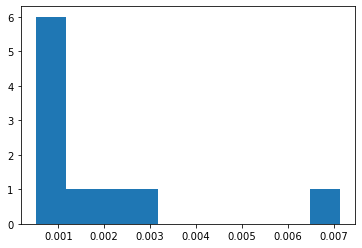

In [31]:
pyplot.hist(np.array

In [ ]:
features = ['boligtype_Leilighet','boligtype_Enebolig','bruksareal','boligtype_Tomannsbolig','postnummer','boligtype_Rekkehus', 
        'neighborhood_environment_demographics_housingage_10-30','neighborhood_environment_demographics_housingprices_0-2000000','neighborhood_environment_demographics_housingage_30-50',
        'eieform_Andel']

## 10-feature model training (Ferdigtrent, lastes inn lenger ned)

In [ ]:


features = ['boligtype_Leilighet','boligtype_Enebolig','bruksareal','boligtype_Tomannsbolig','postnummer','boligtype_Rekkehus', 
'neighborhood_environment_demographics_housingage_10-30','neighborhood_environment_demographics_housingprices_0-2000000','neighborhood_environment_demographics_housingage_30-50',
'eieform_Andel']
train_x = train_x[features]
validation_x = validation_x[features]
test_x = test_x[features] 

parameters = {'activation_1':['relu', 'elu', 'sigmoid', 'tanh'],
 'activation_2':['relu', 'elu', 'sigmoid', 'tanh'],
 'activation_3':['relu', 'elu', 'sigmoid', 'tanh'],
 'optimizer': ['Adam', "RMSprop", 'sgd', 'Nadam'],
 'loss-functions': ['mse'],
 'neurons_HL1': [5, 10, 20, 50, 100],
 'neurons_HL2': [5, 10, 20, 50, 100],
 'neurons_HL3': [5, 10, 20, 50, 100, None],
 'dropout1': [0.1, 0.2, 0.3],
 'dropout2': [0.0, 0.1, 0.2, 0.3],
 'batch_size': [100, 250, 500],
 'epochs': [3000]
}
    



def talolos(x_train, y_train, x_val, y_val, parameters):
    model = Sequential()

    model.add(Dense(parameters['neurons_HL1'],
                    input_shape=(train_x.shape[1],),
                    activation=parameters['activation_1'], use_bias=True))

    model.add(Dropout(parameters['dropout1']))
    model.add(Dense(parameters['neurons_HL2'], activation=parameters['activation_2'], use_bias=True))
    model.add(Dropout(parameters['dropout1']))

    if parameters['neurons_HL3']:
        model.add(Dense(parameters['neurons_HL3'], activation=parameters['activation_3'], use_bias=True))

    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=parameters['optimizer'], loss=parameters['loss-functions'], metrics=['mse', 'mae'])

    history = model.fit(x_train, y_train,
                        batch_size=parameters['batch_size'], epochs=parameters['epochs'],
                        verbose=0, validation_data=[x_val, y_val],
                        callbacks=[early_stopper(epochs=parameters['epochs'],
                                                 mode='moderate', monitor='val_loss', patience=40)])

    return history, model

t = talos.Scan(x=np.array(train_x),
               y=np.array(train_y),
               x_val=np.array(validation_x),
               y_val=np.array(validation_y),
               model=talolos,
               params=parameters,
               experiment_name='talos_training',
               round_limit=10)


## Best model

In [ ]:
best_model_10 = t.best_model(metric='loss', asc=True)
best_model_10.save(f'../talos_training/best_model_10.h5')

## Load 10-best model

In [ ]:
from keras.models import load_model
best_model_10 = load_model(f'../talos_training/best_model_10.h5')


## Predict

In [ ]:
predictions = pd.DataFrame()
predictions['pred'] = my_model.predict(test_x)
print(predictions['pred'])